Plot info about Allen dataset subset that we use.

We use 8 areas: 6 visual cortical areas (V1, LM, AL, RL, AM, PM) and 2 thalamic (LGN, LP).

below mapping from Rudelt at el (found in github code):
    structures = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam", "LGd", "LP"]
    structures_names = ["V1", "LM", "RL", "AL", "PM", "AM", "LGN", "LP"]

Plots based on 30min dataset (trimmed beforehand).

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\'
fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

In [38]:
# the order is like in Siegle paper
brain_areas = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

# quality thresholds
amplitude_cutoff = 0.01 # Allen default is 0.1, this one is from Rudelt
isi_violations = 0.5 # default Allen
presence_ratio = 0.9 # default Allen

quality_query = 'amplitude_cutoff < @amplitude_cutoff and isi_violations < @isi_violations and presence_ratio > @presence_ratio'

### Get data

In [39]:
csv_data_file = dataset_folder + 'cut_30min\\sua_list.csv'
with open(csv_data_file, newline='') as f:
    reader = csv.reader(f)
    sua_list = list(reader)
print(f'Loaded N units {len(sua_list)}')

Loaded N units 18168


In [40]:
column_names = ["specimen_id", "session_id", "unit_id", "ecephys_structure_acronym", 'firing_rate', 'amplitude_cutoff', 'isi_violations', 'presence_ratio']
units_df = pd.DataFrame([row[:8] for row in sua_list], columns=column_names)
units_df[['firing_rate', 'amplitude_cutoff', 'isi_violations', 'presence_ratio']] = \
    units_df[['firing_rate', 'amplitude_cutoff', 'isi_violations', 'presence_ratio']].astype(float)
n_spikes_l = [len(row[8:]) for row in sua_list]
fr_hz_spont_30min_l = [n_spikes / (30 * 60) for n_spikes in n_spikes_l]
units_df['fr_hz_spont_30min'] = fr_hz_spont_30min_l
units_df['fr_hz_spont_30min_log10'] = np.log10(units_df['fr_hz_spont_30min'])
print(f'N units from all areas {len(units_df)}')

units_subset_df = units_df[units_df['ecephys_structure_acronym'].isin(brain_areas)].copy()
print(f'N units from 8 areas {len(units_subset_df)}')

units_subset_df_quality = units_subset_df.query(quality_query).copy()
print(f'N units from 8 areas constraints by quality metrics {len(units_subset_df_quality)}')

N units from all areas 18168
N units from 8 areas 9279
N units from 8 areas constraints by quality metrics 5775


### Store constraint dataset (csv and dataframe with info)

In [64]:
included_units = units_subset_df_quality['unit_id'].values
sua_list_subset = [row for row in sua_list if row[2] in included_units]

In [66]:
verbose = False
output_filename = dataset_folder + 'cut_30min\\sua_list_constrained.csv'
with open(output_filename, 'a', newline='') as f:
    writer = csv.writer(f)
    for unit in sua_list_subset:
        if verbose:
            print('Writing unit {}'.format(unit[2]))
        writer.writerow(unit)

In [69]:
units_subset_df_quality.to_pickle(dataset_folder + 'cut_30min\\sua_list_constrained_units_df.pkl')

### Plot

In [51]:
save_fig = True

#### Number of units per area

In [41]:
units_per_area_df = units_subset_df_quality.groupby(by='ecephys_structure_acronym', as_index=False)['unit_id'].count()
units_per_area_df.rename(columns={'unit_id':'n_units'}, inplace=True)
units_per_area_df

,ecephys_structure_acronym,n_units
0,LGd,254
1,LP,599
2,VISal,928
3,VISam,912
4,VISl,727
5,VISp,1063
6,VISpm,586
7,VISrl,706


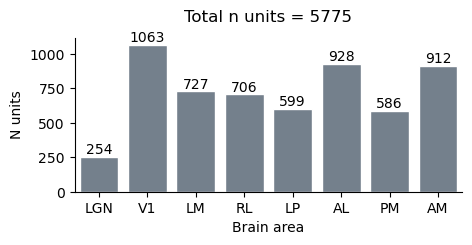

In [52]:
fig, axes = plt.subplots(1,1, figsize=(5,2))

sns.barplot(ax=axes, x='ecephys_structure_acronym', y='n_units', data=units_per_area_df, 
            color='slategray', edgecolor='white', order=brain_areas)
labels = [str(int(v)) if v else '' for v in axes.containers[0].datavalues]
axes.bar_label(axes.containers[0], labels=labels)
axes.set_xlabel('Brain area')
axes.set_ylabel('N units')
axes.set_xticks(brain_areas)
axes.set_xticklabels(brain_areas_names)

axes.set_title(f'Total n units = {len(units_subset_df_quality)}', y=1.05)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'n_units_per_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_units_per_area.svg' , bbox_inches='tight')

#### Firing rate per area

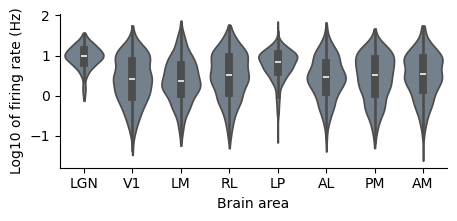

In [53]:
fig, axes = plt.subplots(1, 1, figsize=(5,2))

sns.violinplot(ax=axes, x='ecephys_structure_acronym', y='fr_hz_spont_30min_log10', data=units_subset_df_quality, 
               cut=0, density_norm='width', color='slategray', order=brain_areas)
axes.set_xlabel('Brain area')
axes.set_ylabel('Log10 of firing rate (Hz)')
axes.set_xticks(brain_areas)
axes.set_xticklabels(brain_areas_names)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'fr_per_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'fr_per_area.svg' , bbox_inches='tight')